In [1]:
pip install tqdm

  Using cached tqdm-4.64.0-py2.py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

     |████████████████████████████████| 20.8 MB 5.6 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 91.3 MB/s eta 0:00:01
     |████████████████████████████████| 14.9 MB 95.2 MB/s eta 0:00:01
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
     |████████████████████████████████| 462 kB 75.9 MB/s eta 0:00:01
  Created wheel for grpcio: filename=grpcio-1.32.0-cp39-cp39-linux_x86_64.whl size=3436788 sha256=97f27f0a164468aa9df040730717d16dde9a3c3b77f02f17bd1b06f5f4ff32ed
  Stored in directory: /home/jovyan/.cache/pip/wheels/28/95/38/61aa534c5c1a6f5d4af386f1ac4cafa4828c306660e4c861db
  Created wheel for wrapt: filename=wrapt-1.12.1-cp39-cp39-linux_x86_64.whl size=36786 sha256=d64b448deb760ad27a6e3ece6dca55364f531d41c8244f8e606e7d4308cc2bf1
  Stored in directory: /home/jovyan/.cache/pip/wheels/98/23/68/efe259aaca055e93b08e74fbe512819c69a2155c11ba3c0f10
Successfully built grpcio wrapt
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Unin

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python

  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install opencv-python-headless

  Using cached opencv_python_headless-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (48.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import tensorflow as tf
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.layers import concatenate, Input, Activation, Add, Conv2D, Lambda, UpSampling2D
from tensorflow.keras.models import Model
import os
from absl import app, flags, logging
from absl.flags import FLAGS
import os
import cv2
import pathlib
import numpy as np
import tensorflow as tf
import functools
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, LeakyReLU
from tensorflow.keras import Model
from absl import app, flags, logging
from absl.flags import FLAGS
import os
import tqdm
import glob
import random
import tensorflow as tf

In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:


def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))



def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def make_example_bin(img_name, hr_img_str, lr_img_str):
    # Create a dictionary with features that may be relevant (binary).
    feature = {'image/img_name': _bytes_feature(img_name),
               'image/hr_encoded': _bytes_feature(hr_img_str),
               'image/lr_encoded': _bytes_feature(lr_img_str)}

    return tf.train.Example(features=tf.train.Features(feature=feature))


def make_example(img_name, hr_img_path, lr_img_path):
    # Create a dictionary with features that may be relevant.
    feature = {'image/img_name': _bytes_feature(img_name),
               'image/hr_img_path': _bytes_feature(hr_img_path),
               'image/lr_img_path': _bytes_feature(lr_img_path)}

    return tf.train.Example(features=tf.train.Features(feature=feature))


def MakeTfrecord(hr_dataset_path,lr_dataset_path,output_path,is_binary):

    if not os.path.isdir(hr_dataset_path):
        logging.info('Please define valid dataset path.')
    else:
        logging.info('Loading {}'.format(hr_dataset_path))

    samples = []
    logging.info('Reading data list...')
    
    for hr_img_path in glob.glob(os.path.join(hr_dataset_path, '*.png')):
        img_name = os.path.basename(hr_img_path).replace('.png', '')
        lr_img_path = os.path.join(lr_dataset_path, img_name + 'x2.png')
        samples.append((img_name, hr_img_path, lr_img_path))
    random.shuffle(samples)

    if os.path.exists(output_path):
        logging.info('{:s} already exists. Exit...'.format(output_path))
        exit(1)

    logging.info('Writing {} sample to tfrecord file...'.format(len(samples)))
    with tf.io.TFRecordWriter(output_path) as writer:
        for img_name, hr_img_path, lr_img_path in tqdm.tqdm(samples):
            if is_binary:
                hr_img_str = open(hr_img_path, 'rb').read()
                lr_img_str = open(lr_img_path, 'rb').read()
                tf_example = make_example_bin(img_name=str.encode(img_name), hr_img_str=hr_img_str,lr_img_str=lr_img_str)
            else:
                tf_example = make_example(img_name=str.encode(img_name),
                                          hr_img_path=str.encode(hr_img_path),lr_img_path=str.encode(lr_img_path))
            writer.write(tf_example.SerializeToString())

# TFrecord train data 

In [12]:
train_hr_dataset_path='./data/DIV2K_train_HR/' # 'path to high resolution dataset'
train_lr_dataset_path='./data/DIV2K_train_LR_bicubic/X2/'#'path to low resolution dataset')
train_output_path='./data/DIV2K720_sub_bin.tfrecord'#'path to ouput tfrecord')
is_binary=True #'whether save images as binary files'' or load them on the fly.')
MakeTfrecord(train_hr_dataset_path,train_lr_dataset_path,train_output_path,is_binary)

100%|██████████| 720/720 [00:11<00:00, 64.19it/s]


# TFrecord validation data 

In [13]:
train_hr_dataset_path='./data/DIV2K_valid_HR/' # 'path to high resolution dataset'
train_lr_dataset_path='./data/DIV2K_valid_LR_bicubic/X2/'#'path to low resolution dataset')
train_output_path='./data/DIV2K180_sub_bin.tfrecord'#'path to ouput tfrecord')
is_binary=True #'whether save images as binary files'' or load them on the fly.')
MakeTfrecord(train_hr_dataset_path,train_lr_dataset_path,train_output_path,is_binary)

100%|██████████| 180/180 [00:05<00:00, 30.54it/s]


In [10]:
def load_dataset(pathTf,key, shuffle=True, buffer_size=32):
    """load dataset"""
    dataset_cfg = pathTf
    logging.info("load {} from {}".format(key, pathTf))
    dataset = load_tfrecord_dataset(
        tfrecord_name= pathTf, batch_size= 10 ,gt_size= 128 ,scale= 2, shuffle=shuffle , using_bin= True , using_flip= True,using_rot=True , buffer_size=buffer_size)
    
    return dataset


In [11]:
def load_tfrecord_dataset(tfrecord_name, batch_size, gt_size,scale, using_bin=False, using_flip=False, using_rot=False, shuffle=True, buffer_size=10240):
    """load dataset from tfrecord"""
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.repeat()
    if shuffle:
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)
    dataset = raw_dataset.map(_parse_tfrecord(gt_size, scale, using_bin, using_flip, using_rot),num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch( buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [12]:
def _parse_tfrecord(gt_size, scale, using_bin, using_flip, using_rot):
    def parse_tfrecord(tfrecord):
        if using_bin:
            features = {
                'image/img_name': tf.io.FixedLenFeature([], tf.string),
                'image/hr_encoded': tf.io.FixedLenFeature([], tf.string),
                'image/lr_encoded': tf.io.FixedLenFeature([], tf.string)}
            x = tf.io.parse_single_example(tfrecord, features)
            lr_img = tf.image.decode_png(x['image/lr_encoded'], channels=3)
            hr_img = tf.image.decode_png(x['image/hr_encoded'], channels=3)
        else:
            features = {
                'image/img_name': tf.io.FixedLenFeature([], tf.string),
                'image/hr_img_path': tf.io.FixedLenFeature([], tf.string),
                'image/lr_img_path': tf.io.FixedLenFeature([], tf.string)}
            x = tf.io.parse_single_example(tfrecord, features)
            hr_image_encoded = tf.io.read_file(x['image/hr_img_path'])
            lr_image_encoded = tf.io.read_file(x['image/lr_img_path'])
            lr_img = tf.image.decode_png(lr_image_encoded, channels=3)
            hr_img = tf.image.decode_png(hr_image_encoded, channels=3)

        lr_img, hr_img = _transform_images(gt_size, scale, using_flip, using_rot)(lr_img, hr_img)
        
        
        return lr_img, hr_img
    return parse_tfrecord

In [13]:
def _transform_images(gt_size, scale, using_flip, using_rot):
    def transform_images(lr_img, hr_img):
        lr_img_shape = tf.shape(lr_img)
        hr_img_shape = tf.shape(hr_img)
        gt_shape = (gt_size, gt_size, tf.shape(hr_img)[-1])
        lr_size = int(gt_size / scale)
        lr_shape = (lr_size, lr_size, tf.shape(lr_img)[-1])

        tf.Assert(
            tf.reduce_all(hr_img_shape >= gt_shape),
            ["Need hr_image.shape >= gt_size, got ", hr_img_shape, gt_shape])
        tf.Assert(
            tf.reduce_all(hr_img_shape[:-1] == lr_img_shape[:-1] * scale),
            ["Need hr_image.shape == lr_image.shape * scale, got ",
             hr_img_shape[:-1], lr_img_shape[:-1] * scale])
        tf.Assert(
            tf.reduce_all(hr_img_shape[-1] == lr_img_shape[-1]),
            ["Need hr_image.shape[-1] == lr_image.shape[-1]], got ",
             hr_img_shape[-1], lr_img_shape[-1]])

        # randomly crop
        limit = lr_img_shape - lr_shape + 1
        offset = tf.random.uniform(tf.shape(lr_img_shape), dtype=tf.int32,
                                   maxval=tf.int32.max) % limit
        lr_img = tf.slice(lr_img, offset, lr_shape)
        hr_img = tf.slice(hr_img, offset * scale, gt_shape)

        # randomly left-right flip
        if using_flip:
            flip_case = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            def flip_func(): return (tf.image.flip_left_right(lr_img),
                                     tf.image.flip_left_right(hr_img))
            lr_img, hr_img = tf.case(
                [(tf.equal(flip_case, 0), flip_func)],
                default=lambda: (lr_img, hr_img))

        # randomly rotation
        if using_rot:
            rot_case = tf.random.uniform([1], 0, 4, dtype=tf.int32)
            def rot90_func(): return (tf.image.rot90(lr_img, k=1),
                                      tf.image.rot90(hr_img, k=1))
            def rot180_func(): return (tf.image.rot90(lr_img, k=2),
                                       tf.image.rot90(hr_img, k=2))
            def rot270_func(): return (tf.image.rot90(lr_img, k=3),
                                       tf.image.rot90(hr_img, k=3))
            lr_img, hr_img = tf.case(
                [(tf.equal(rot_case, 0), rot90_func),
                 (tf.equal(rot_case, 1), rot180_func),
                 (tf.equal(rot_case, 2), rot270_func)],
                default=lambda: (lr_img, hr_img))

        # scale to [0, 1]
        lr_img = lr_img / 255
        hr_img = hr_img / 255
        
        return lr_img, hr_img
    return transform_images

In [16]:
train_dataset  =  load_dataset('./data/DIV2K720_sub_bin.tfrecord','train_dataset', shuffle=False)

In [17]:
valid_dataset  =  load_dataset('./data/DIV2K180_sub_bin.tfrecord','valid_dataset', shuffle=False)

In [18]:
print(train_dataset)

<PrefetchDataset shapes: ((10, 64, 64, None), (10, 128, 128, None)), types: (tf.float32, tf.float32)>


In [19]:
print(valid_dataset)

<PrefetchDataset shapes: ((10, 64, 64, None), (10, 128, 128, None)), types: (tf.float32, tf.float32)>


In [20]:
 def _pixel_shuffle(input_layer):
        """ PixelShuffle implementation of the upscaling layer. """
        initializer = RandomUniform( minval=-0.05, maxval=0.05, seed=None)
        x = Conv2D(
            3 * 2 ** 2,
            kernel_size=3,
            padding='same',
            name='UPN3',
            kernel_initializer=initializer,
        )(input_layer)
        return Lambda(
            lambda x: tf.nn.depth_to_space(x, block_size=2, data_format='NHWC'),
            name='PixelShuffle',
        )(x)

In [21]:
def _upsampling_block( input_layer):
    """ Upsampling block for old weights. """
    initializer = RandomUniform( minval=-0.05, maxval=0.05, seed=None)
    scale=2
    x = Conv2D(
        3 * scale ** 2,
        kernel_size=3,
        padding='same',
        name='UPN3',
        kernel_initializer=initializer,
    )(input_layer)
    return UpSampling2D(size=scale, name='UPsample')(x)

In [22]:
def _UPN(input_layer):
    upscaling='shuffle'
    """ Upscaling layers. With old weights use _upsampling_block instead of _pixel_shuffle. """
    initializer = RandomUniform( minval=-0.05, maxval=0.05, seed=None)
    x = Conv2D(
        64,
        kernel_size=5,
        strides=1,
        padding='same',
        name='UPN1',
        kernel_initializer=initializer,
    )(input_layer)
    x = Activation('relu', name='UPN1_Relu')(x)
    x = Conv2D(
        32, kernel_size=3, padding='same', name='UPN2', kernel_initializer=initializer
    )(x)
    x = Activation('relu', name='UPN2_Relu')(x)
    if upscaling == 'shuffle':
        return _pixel_shuffle(x)
    elif upscaling == 'ups':
        return _upsampling_block(x)
    else:
        raise ValueError('Invalid choice of upscaling layer.')

In [23]:
def _RDBs(input_layer):
        """RDBs blocks.
        Args:
            input_layer: input layer to the RDB blocks (e.g. the second convolutional layer F_0).
        Returns:
            concatenation of RDBs output feature maps with G0 feature maps.
        """
        initializer = RandomUniform( minval=-0.05, maxval=0.05, seed=None)
        rdb_concat = list()
        rdb_in = input_layer
        for d in range(1, 20+ 1):
            x = rdb_in
            for c in range(1, 6 + 1):
                F_dc = Conv2D(
                    64,
                    kernel_size=3,
                    padding='same',
                    kernel_initializer=initializer,
                    name='F_%d_%d' % (d, c),
                )(x)
                F_dc = Activation('relu', name='F_%d_%d_Relu' % (d, c))(F_dc)
                # concatenate input and output of ConvRelu block
                # x = [input_layer,F_11(input_layer),F_12([input_layer,F_11(input_layer)]), F_13..]
                x = concatenate([x, F_dc], axis=3, name='RDB_Concat_%d_%d' % (d, c))
            # 1x1 convolution (Local Feature Fusion)
            x = Conv2D(
                64, kernel_size=1, kernel_initializer=initializer, name='LFF_%d' % (d)
            )(x)
            # Local Residual Learning F_{i,LF} + F_{i-1}
            rdb_in = Add(name='LRL_%d' % (d))([x, rdb_in])
            rdb_concat.append(rdb_in)
        
        assert len(rdb_concat) == 20
        
        return concatenate(rdb_concat, axis=3, name='LRLs_Concat')

In [24]:
initializer = RandomUniform( minval=-0.05, maxval=0.05, seed=None)

In [25]:
LR_input = Input(shape=(None, None, 3), name='LR')
F_m1 = Conv2D( 64,kernel_size=3,padding='same',kernel_initializer=initializer,name='F_m1',)(LR_input)
F_0 = Conv2D(64,kernel_size=3,padding='same',kernel_initializer=initializer,name='F_0',)(F_m1)
FD = _RDBs(F_0)
# Global Feature Fusion
# 1x1 Conv of concat RDB layers -> G0 feature maps
GFF1 = Conv2D(64,kernel_size=1,padding='same',kernel_initializer=initializer,name='GFF_1',)(FD)

GFF2 = Conv2D(64,kernel_size=3,padding='same',kernel_initializer=initializer,name='GFF_2',)(GFF1)
# Global Residual Learning for Dense Features
FDF = Add(name='FDF')([GFF2, F_m1])
# Upscaling
FU = _UPN(FDF)
# Compose SR image
SR = Conv2D(3,kernel_size=3,padding='same',kernel_initializer=initializer,name='SR',)(FU)
        
Model_RDN=Model(inputs=LR_input, outputs=SR)

In [26]:
Model_RDN.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
LR (InputLayer)                 [(None, None, None,  0                                            
__________________________________________________________________________________________________
F_m1 (Conv2D)                   (None, None, None, 6 1792        LR[0][0]                         
__________________________________________________________________________________________________
F_0 (Conv2D)                    (None, None, None, 6 36928       F_m1[0][0]                       
__________________________________________________________________________________________________
F_1_1 (Conv2D)                  (None, None, None, 6 36928       F_0[0][0]                        
______________________________________________________________________________________________

In [27]:
Model_RDN.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics='accuracy')

In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [30]:
history=Model_RDN.fit(train_dataset,epochs=100,batch_size=10,steps_per_epoch=72,validation_data=valid_dataset,
              validation_steps=18,callbacks=[callback])

Epoch 1/100


2022-06-10 16:58:31.039620: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-06-10 16:58:33.799874: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-06-10 16:58:33.870544: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-06-10 16:58:34.845204: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


72/72 [==============================] - 108s 939ms/step - loss: 1.1435 - accuracy: 0.3520 - val_loss: 0.0790 - val_accuracy: 0.3954
Epoch 2/100
72/72 [==============================] - 66s 916ms/step - loss: 0.0392 - accuracy: 0.3309 - val_loss: 0.0290 - val_accuracy: 0.3465
Epoch 3/100
72/72 [==============================] - 66s 912ms/step - loss: 0.0262 - accuracy: 0.3586 - val_loss: 0.0240 - val_accuracy: 0.3449
Epoch 4/100
72/72 [==============================] - 66s 914ms/step - loss: 0.0195 - accuracy: 0.4287 - val_loss: 0.0167 - val_accuracy: 0.5563
Epoch 5/100
72/72 [==============================] - 67s 929ms/step - loss: 0.0204 - accuracy: 0.4231 - val_loss: 0.0180 - val_accuracy: 0.3571
Epoch 6/100
72/72 [==============================] - 68s 951ms/step - loss: 0.0161 - accuracy: 0.4821 - val_loss: 0.0129 - val_accuracy: 0.6021
Epoch 7/100
72/72 [==============================] - 70s 976ms/step - loss: 0.0144 - accuracy: 0.5407 - val_loss: 0.0100 - val_accuracy: 0.6097
Epo

72/72 [==============================] - 69s 966ms/step - loss: 0.0027 - accuracy: 0.8170 - val_loss: 0.0013 - val_accuracy: 0.8711
Epoch 59/100
72/72 [==============================] - 69s 966ms/step - loss: 0.0016 - accuracy: 0.8815 - val_loss: 0.0014 - val_accuracy: 0.8440
Epoch 60/100
72/72 [==============================] - 70s 971ms/step - loss: 0.0016 - accuracy: 0.8845 - val_loss: 0.0019 - val_accuracy: 0.8610
Epoch 61/100
72/72 [==============================] - 69s 964ms/step - loss: 0.0014 - accuracy: 0.8777 - val_loss: 0.0013 - val_accuracy: 0.8980
Epoch 62/100
72/72 [==============================] - 69s 960ms/step - loss: 0.0013 - accuracy: 0.8947 - val_loss: 0.0013 - val_accuracy: 0.8739
Epoch 63/100
72/72 [==============================] - 70s 975ms/step - loss: 0.0014 - accuracy: 0.8942 - val_loss: 0.0012 - val_accuracy: 0.8804
Epoch 64/100
72/72 [==============================] - 69s 966ms/step - loss: 0.0016 - accuracy: 0.8681 - val_loss: 0.0015 - val_accuracy: 0.865

In [53]:
Model_RDN.save('RDNt69.h5') 

In [32]:
import matplotlib.pyplot as plt

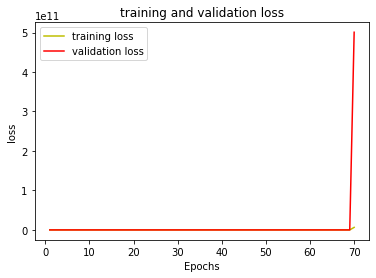

In [34]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label="training loss")
plt.plot(epochs,val_loss,'r',label="validation loss")
plt.title("training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

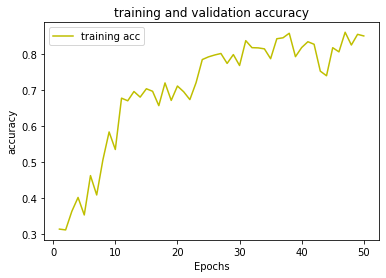

In [29]:
acc=history.history["accuracy"]
#val_acc=history.history["val_accuracy"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,acc,'y',label="training acc")
#plt.plot(epochs,val_acc,'r',label="validation acc")
plt.title("training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [35]:
print(history.history)

{'loss': [1.143545389175415, 0.039181556552648544, 0.026184765622019768, 0.019485026597976685, 0.020394589751958847, 0.016139376908540726, 0.014419084414839745, 0.009573547169566154, 0.008269475772976875, 0.00774100236594677, 0.007142333313822746, 0.007465492933988571, 0.00621396629139781, 0.005557700525969267, 0.0053597670048475266, 0.005116801708936691, 0.00519446050748229, 0.0045898426324129105, 0.0042161461897194386, 0.004692824557423592, 0.004768889397382736, 0.003938605543226004, 0.0046768514439463615, 0.004241384100168943, 0.003217921359464526, 0.0027571299578994513, 0.0028925505466759205, 0.0025556364562362432, 0.00232875719666481, 0.0021640330087393522, 0.0020254813134670258, 0.002214334439486265, 0.0020808347035199404, 0.0021900308784097433, 0.0019067518878728151, 0.002463625045493245, 0.0022262188140302896, 0.0017753839492797852, 0.0019831445533782244, 0.0018962717149406672, 0.0019397513242438436, 0.0019565243273973465, 0.001684758928604424, 0.0016949651762843132, 0.00177413

In [49]:
history={'loss': [1.143545389175415, 0.039181556552648544, 0.026184765622019768, 0.019485026597976685, 0.020394589751958847, 0.016139376908540726, 0.014419084414839745, 0.009573547169566154, 0.008269475772976875, 0.00774100236594677, 0.007142333313822746, 0.007465492933988571, 0.00621396629139781, 0.005557700525969267, 0.0053597670048475266, 0.005116801708936691, 0.00519446050748229, 0.0045898426324129105, 0.0042161461897194386, 0.004692824557423592, 0.004768889397382736, 0.003938605543226004, 0.0046768514439463615, 0.004241384100168943, 0.003217921359464526, 0.0027571299578994513, 0.0028925505466759205, 0.0025556364562362432, 0.00232875719666481, 0.0021640330087393522, 0.0020254813134670258, 0.002214334439486265, 0.0020808347035199404, 0.0021900308784097433, 0.0019067518878728151, 0.002463625045493245, 0.0022262188140302896, 0.0017753839492797852, 0.0019831445533782244, 0.0018962717149406672, 0.0019397513242438436, 0.0019565243273973465, 0.001684758928604424, 0.0016949651762843132, 0.0017741319024935365, 0.0015586253721266985, 0.0016021174378693104, 0.002775428583845496, 0.002755315974354744, 0.0016485184896737337, 0.0017363016959279776, 0.0014850300503894687, 0.0014983302680775523, 0.0014944279100745916, 0.0014517651870846748, 0.0016268243780359626, 0.0018238755874335766, 0.0027146749198436737, 0.0016392860561609268, 0.0015761317918077111, 0.0014428769936785102, 0.001349681755527854, 0.0013867189409211278, 0.0016098725609481335, 0.0015393919311463833, 0.001277188421227038, 0.0014622247545048594, 0.0013207492884248495, 0.0013556669000536203], 'accuracy': [0.3519819378852844, 0.3308543860912323, 0.35861706733703613, 0.4287217855453491, 0.42312079668045044, 0.4821428060531616, 0.5407211184501648, 0.6375065445899963, 0.6753717064857483, 0.6673515439033508, 0.6751797795295715, 0.6639456748962402, 0.710767388343811, 0.6783375144004822, 0.6969262957572937, 0.6949719786643982, 0.6773665547370911, 0.7129318118095398, 0.7210499048233032, 0.7160130739212036, 0.7149475812911987, 0.7091739177703857, 0.7274995446205139, 0.710463285446167, 0.7594233155250549, 0.800852358341217, 0.7996453046798706, 0.8202683329582214, 0.8274221420288086, 0.8416674137115479, 0.8508272767066956, 0.8520705103874207, 0.8437631130218506, 0.8153584599494934, 0.8459581732749939, 0.8285733461380005, 0.83941251039505, 0.8569388389587402, 0.8532771468162537, 0.8505804538726807, 0.8517544269561768, 0.8315516114234924, 0.861225962638855, 0.8720583319664001, 0.8587255477905273, 0.8643180131912231, 0.865946352481842, 0.8339611291885376, 0.8104261755943298, 0.8646810054779053, 0.8777023553848267, 0.8810117840766907, 0.8850943446159363, 0.8832262754440308, 0.8852392435073853, 0.8749329447746277, 0.8439991474151611, 0.8170252442359924, 0.8814613223075867, 0.8845369815826416, 0.8777494430541992, 0.8946653604507446, 0.894172728061676, 0.8680646419525146, 0.8600699305534363, 0.8867310285568237, 0.8862438797950745, 0.8824796676635742, 0.8831440210342407], 'val_loss': [0.07898929715156555, 0.02897581085562706, 0.024003425613045692, 0.01665608026087284, 0.018012795597314835, 0.01287408359348774, 0.01004430279135704, 0.0085562439635396, 0.007808216847479343, 0.006377830635756254, 0.006931703072041273, 0.006502110976725817, 0.005238046869635582, 0.0055085732601583, 0.004821157548576593, 0.004712562542408705, 0.005133155733346939, 0.004523712210357189, 0.0036114943213760853, 0.00596263213083148, 0.0038504914846271276, 0.004208590369671583, 0.005112561397254467, 0.003327248152345419, 0.0029015918262302876, 0.002027514623478055, 0.002715164329856634, 0.0021170545369386673, 0.002112988382577896, 0.0020050075836479664, 0.002002810826525092, 0.0019699474796652794, 0.0017447174759581685, 0.0018651429563760757, 0.00180103350430727, 0.00217621261253953, 0.0014440629165619612, 0.001799505902454257, 0.0019026411464437842, 0.0015022966545075178, 0.0016226565930992365, 0.001522505423054099, 0.0014332049759104848, 0.001553406473249197, 0.001718410523608327, 0.0014849662547931075, 0.0014126916648820043, 0.0053129722364246845, 0.0019042682833969593, 0.0016160756349563599, 0.0016252597561106086, 0.0014926239382475615, 0.0014851725427433848, 0.0014980497071519494, 0.0014135354431346059, 0.001348881865851581, 0.0021819183602929115, 0.0013455752050504088, 0.0014006091514602304, 0.0018540523014962673, 0.001332071959041059, 0.0013029957190155983, 0.001236607669852674, 0.0015205243835225701, 0.0012706221314147115, 0.0012707248097285628, 0.0009507948416285217, 0.0012283999240025878, 0.0010110742878168821], 'val_accuracy': [0.3954305052757263, 0.3464745283126831, 0.3449249267578125, 0.5562740564346313, 0.35706040263175964, 0.6020826697349548, 0.6096805334091187, 0.6292344927787781, 0.617983341217041, 0.6711181402206421, 0.634922981262207, 0.6915706992149353, 0.7046274542808533, 0.6690948605537415, 0.6748213171958923, 0.7053138017654419, 0.698392391204834, 0.7002156376838684, 0.67939692735672, 0.6810367107391357, 0.6718597412109375, 0.6991366744041443, 0.6775532960891724, 0.7270782589912415, 0.7791720628738403, 0.8145602941513062, 0.8127037882804871, 0.8393205404281616, 0.8145087361335754, 0.807039737701416, 0.845616340637207, 0.8281134963035583, 0.8206163048744202, 0.8051432371139526, 0.858731746673584, 0.8347412347793579, 0.8561608195304871, 0.8640882968902588, 0.8696801066398621, 0.8601057529449463, 0.83228999376297, 0.8545172810554504, 0.8635331988334656, 0.8821621537208557, 0.8385311365127563, 0.8417568802833557, 0.8248029947280884, 0.7624375820159912, 0.836090087890625, 0.8649492263793945, 0.8626126050949097, 0.8728939294815063, 0.8438127040863037, 0.8645820021629333, 0.8672665357589722, 0.8841990232467651, 0.8029080033302307, 0.8710662722587585, 0.8440409302711487, 0.8609537482261658, 0.8980275392532349, 0.8739274740219116, 0.8804066777229309, 0.8651994466781616, 0.8890625238418579, 0.8865712285041809, 0.8969794511795044, 0.8641835451126099, 0.8805630207061768]}


In [50]:
print(history)

{'loss': [1.143545389175415, 0.039181556552648544, 0.026184765622019768, 0.019485026597976685, 0.020394589751958847, 0.016139376908540726, 0.014419084414839745, 0.009573547169566154, 0.008269475772976875, 0.00774100236594677, 0.007142333313822746, 0.007465492933988571, 0.00621396629139781, 0.005557700525969267, 0.0053597670048475266, 0.005116801708936691, 0.00519446050748229, 0.0045898426324129105, 0.0042161461897194386, 0.004692824557423592, 0.004768889397382736, 0.003938605543226004, 0.0046768514439463615, 0.004241384100168943, 0.003217921359464526, 0.0027571299578994513, 0.0028925505466759205, 0.0025556364562362432, 0.00232875719666481, 0.0021640330087393522, 0.0020254813134670258, 0.002214334439486265, 0.0020808347035199404, 0.0021900308784097433, 0.0019067518878728151, 0.002463625045493245, 0.0022262188140302896, 0.0017753839492797852, 0.0019831445533782244, 0.0018962717149406672, 0.0019397513242438436, 0.0019565243273973465, 0.001684758928604424, 0.0016949651762843132, 0.00177413

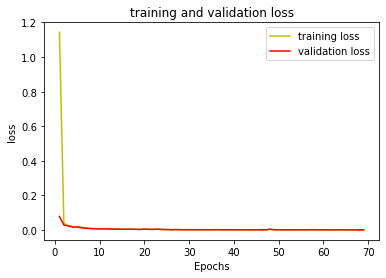

In [51]:
loss=history["loss"]
val_loss=history["val_loss"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label="training loss")
plt.plot(epochs,val_loss,'r',label="validation loss")
plt.title("training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

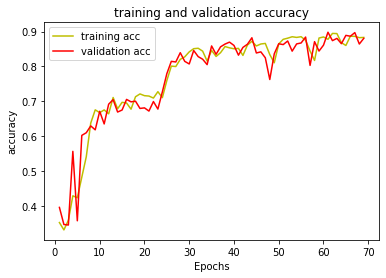

In [52]:
acc=history["accuracy"]
val_acc=history["val_accuracy"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,acc,'y',label="training acc")
plt.plot(epochs,val_acc,'r',label="validation acc")
plt.title("training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()